### GCN Model

In [1]:
# libraries
import os, math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# pytorch
import torch
import torch.nn.functional as F 
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp

# from local files
from custom_dataset import MoleculeDataset
from model import GCN, GAT
from trainer import Trainer
from utils import optimal_cutoff, draw_roc_curve, plot_confusion_matrix, summerize_results

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [3]:
batch_size = 64

In [4]:
train_dataset = MoleculeDataset(root="Dataset/", filename="solubility-dataset-train.csv")
test_dataset = MoleculeDataset(root="Dataset/", filename="solubility-dataset-test.csv", test=True)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
train_loader.dataset.length, test_loader.dataset.length

(8847, 986)

In [7]:
def get_true_test_labels(test_loader):
    y_true_list = []
    for data in test_loader:
        ys = data.y.flatten()
        y_true_list.extend(list(ys.cpu().detach().numpy()))
    return np.array(y_true_list)

In [8]:
# Train and evaluate GCN model
def train_evaluate(params):
    
    hidden_channels = params["hidden_channels"]
    dropout = params["dropout"]
    lr = params["lr"]
    #momentum = params.get("momentum", 0.9)
    weight_decay = params["weight_decay"]
    epochs = params["n_epochs"]
    
    model = GCN(n_features=30, hidden_channels=hidden_channels, dropout=dropout)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    trainer = Trainer(model=model, optimizer=optimizer, train_loader=train_loader, valid_loader=test_loader)
    
    # training
    (train_losses, train_scores), (valid_losses, valid_scores) = trainer.run(n_epochs=epochs)
    
    # prediction on test/valid loader
    y_proba = trainer.predict(test_loader)
    y_true = get_true_test_labels(test_loader=test_loader)
    test_auc = roc_auc_score(y_true, y_proba)
    return (train_losses, train_scores), (valid_losses, valid_scores), (y_true, y_proba)

In [9]:
# training params
params = {
          "hidden_channels": 128, 
          "dropout": 0.4, 
          "lr": 0.01, 
          "weight_decay": 7e-5, 
          "n_epochs": 50
         }

# training and evaulation
(train_losses, train_scores), (valid_losses, valid_scores), (y_true, y_proba) = train_evaluate(params)

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
N_EPOCHS = params["n_epochs"]

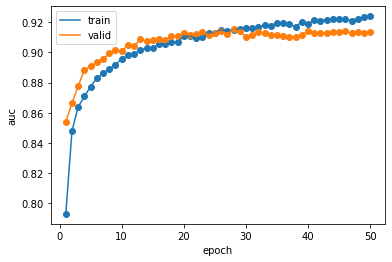

In [11]:
epoch_list = np.arange(1, N_EPOCHS+1, 1)

plt.plot(epoch_list, train_scores, label="train")
plt.plot(epoch_list, valid_scores, label="valid");
plt.scatter(epoch_list, train_scores)
plt.scatter(epoch_list, valid_scores);
plt.legend();
plt.ylabel("auc")
plt.xlabel("epoch");

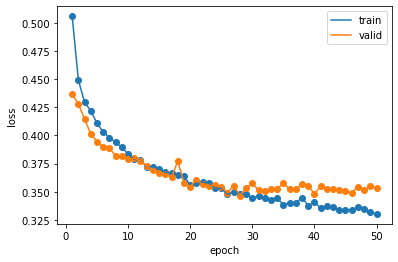

In [12]:
epoch_list = np.arange(1, N_EPOCHS+1, 1)
plt.plot(epoch_list, train_losses, label="train")
plt.plot(epoch_list, valid_losses, label="valid");
plt.scatter(epoch_list, train_losses)
plt.scatter(epoch_list, valid_losses);
plt.legend();
plt.ylabel("loss")
plt.xlabel("epoch");

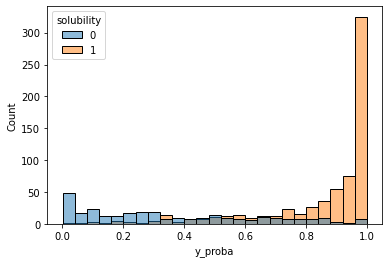

In [13]:
tmp = pd.DataFrame(data={"solubility":  y_true, "y_proba": y_proba})
sns.histplot(x="y_proba", hue="solubility", data=tmp, bins=25);

In [14]:
cutoff = optimal_cutoff(y_true, y_proba)
cutoff

0.69

In [15]:
y_pred = (y_proba > cutoff-0.2).astype(int)

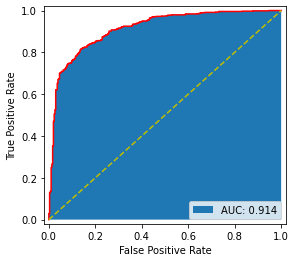

In [16]:
draw_roc_curve(y_true, y_proba)

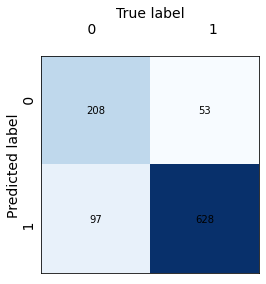

In [17]:
plot_confusion_matrix(y_true, y_pred)

In [18]:
summerize_results(y_true, y_pred)


        RESULTS
Accuracy:  0.85
-------------------------
sensitivity:  0.92
specificity:  0.68
-------------------------
positive predictive value:  0.87
negative predictive value:  0.8
-------------------------
precision:  0.87
recall:  0.92


### Lastly,
- Also, tested the GAT model, but it did rather perform slightly worse than GCN model.
- Unexpectedly, Graph Neural Net models performed even worse than molecular descriptors based model, see the LightGBM model with RDKit Descriptors (123 different molecular properties) in separate Notebook.
    - This paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00479-8 shows that graph based models perform at best as good as descriptor based models for molecular representation of drug molecules.


- TODOs:
    - Implement conformal oversampling for molecules: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00420-z
    - Exhaustive hyper-parameters tuning for GCN model [it's computationally expensive to carry-out more wider search with longer epochs, it took > 12hrs in Dell XPS 15 for 50 runs each with only 20 epochs.]
    - Regression model with GCN for aqueous solubility prediction